In [21]:
#Importing required modules
import os
from numpy import array,random,shape,array_split,transpose,sort,flipud,fliplr,zeros
from operator import xor
from skimage import io
from skimage.color import rgb2gray
from PIL import Image
import numpy as np
import os
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import cv2 
import random
from math import log
from tqdm import tqdm

In [22]:
# FUNCTION: RandomKey
# -- Generates a 256-bit random key (in HEX) using MATLAB RNG
# Output: K = a 256-bit random key in HEX

from numpy import shape,random,array

def dec2hex(string, length):
    #function to convert decimal string to hexadecimal string
    hex_string = ''
    if len(hex(string)) < length: hex_string = hex(string)[:2]+'0'*(8-len(hex(string)))+hex(string)[3:]
    else: hex_string = hex(string)
    return hex_string

def RandomKey(P):
    K = []
    r = []
    sr = ''
    r_ = random.rand(1,256)
    for i in range(256): r.append(round(r_[0][i]))
    for i in range(256): r[i] = str(r[i])[0]
    for i in range(1,9): K.append(dec2hex(int(sr.join(r[((i-1)*32):i*32]),2),8));l=P
    return (array(K),l)

In [23]:
#=============================================================
# FUNCTION: KeyedLatin
# -- Generates n Latin square of order d dependent on key K
# Output:
#       L = 256-by-256-by-m matrix, each of whose layer is a 256x256 Latin
#       square using the symbol set {1,2,...,256}
#=============================================================

def blockproc(matrix,sec,fun):
    #function to apply a particular function to blocks of a matrix
    blocks = []
    matrix_bp = [[]]
    matrix_b = [[] for i in range(256)]
    if sec == 8:
        blocks = array_split(matrix,sec)
        for block in blocks:
            m = fun(block[0])
            matrix_bp[0].append(m)
        matrix_bp = array(matrix_bp)
        return matrix_bp
        
    if sec == 256:
        blocks = array_split(matrix,sec)
        for block in blocks:
            m = fun(block)
            for x in range(256): matrix_b[x].append(m[x][0])
        matrix_b = array(matrix_b)
        return matrix_b

def KeyedLatin(K,m):
    a = 1664525
    c = 1013904223 #LCG parameters suggested in Numerical Recipe
    #Linear Congruential Generator (LCG) PRNG
    lcg = lambda q: (a * q + c) %2**32 

    #Latin Square Generator (LSG) using Row-Shiftings
    lsg_r = lambda qSeed, v: (qSeed+v) %256
    lsg = lambda qSeed, qShift: blockproc(qShift, 256, lambda v: lsg_r(qSeed,v))

    ## Define Key Conversions 
    # Convert Hex Key string to dec sequence
    key_hex_bin = lambda K: blockproc(K,8,lambda k: int(str(k),16))

    ##Generate n Latin squares of order 256
    KDec = key_hex_bin(K) #KDec is a 1x8 array
    L = []
    for n in range(m):
        q = []
        for i in range(64):
            if i == 0: q.append(lcg(KDec))
            else: q.append(lcg(q[i-1]))
        Q1 = []
        Q2 = []
        for x in range(32):
            for y in range(8): Q1.append(q[x][0][y])
        for x in range(32,64):
            for y in range(8): Q2.append(q[x][0][y])

        KDec = q[-1]    #update Key
        Qseed =  sort(Q1) #a 256-element LCG sequence
        Qshift = sort(Q2) #a 256-element LCG sequence
        Qseed = array([Qseed])
        Qshift = array(Qshift)

        L.append(lsg(transpose(Qseed),Qshift))
    return array(L)

In [24]:
#=============================================================
# FUNCTION: LatinSq_Whitening
# -- Generates n Latin square of order d dependent on key K
# Input:
#      inputMatrix = a 256x256 matrix, 
#                L = a 256x256 Latin square with symbol set {0,1,...,255}
#                opt = encryption/decryption
# Output:
#      output = a 256x256 matrix
#=============================================================

def LatinSq_Whitening(inputMatrix,L,opt):
    if opt == None: opt = 'encryption'

    if opt == 'encryption':
        if L[0][0]%3 == 1: inputMatrix = flipud(inputMatrix) #flip the matrix upside down
        if L[0][0]%3 == 2: inputMatrix = fliplr(inputMatrix) #flip the matrix leftside right
        output = (inputMatrix+L)%256

    if opt == 'decryption':
        output = (inputMatrix-L)%256
        if L[0][0]%3 == 1: output = flipud(output)
        if L[0][0]%3 == 2: output = fliplr(output)
    return output

In [25]:
#=============================================================
# FUNCTION: LatinSq_Permutation
# -- Permutate image pixels 
# Input:
#       input = a 256x256 matrix, 
#           L = a 256x256 Latin square with symbol set {0,1,...,255}
#         opt = 'encryption'/'decryption'
# Ouptut:
#      output = a 256x256 matrix
#=============================================================
def LatinSq_Permutation(input, L, opt):
    if opt == None: opt = 'encryption'
    output = zeros((256,256),dtype='int')
    tmp = zeros((256,256),dtype='int')
    if opt == 'encryption':
        for i in range(256): tmp[i,:] = input[i,L[i,:]] #row permutations
        for i in range(256): output[:,i] = tmp[L[:,i],i] #column permutations

    if opt == 'decryption':
        for i in range(256): tmp[L[:,i],i] = input[0:256,i]
        for i in range(256): output[i,L[i,:]] = tmp[i,0:256]
    return output

In [26]:
#=============================================================
# FUNCTION: LatinSqEnc2
# -- Encrypt an image
# Input:
#       P = a 256x256 matrix, 
#       K = a hexadecimal key sequence
# Ouptut:
#      output = a 256x256 matrix
#=============================================================
def bitget(x,y):
    bit = int(bin(x[0][y])[2:])
    return bit

def LatinSqEnc2(P,K=None):
    #Generate a random key
    if K == None:
        K_ = None
        K = RandomKey(P)
        opt = 'NPE'

    #Probabilistic encryption
    #Generate a random 256x256 Latin
    M_ = random.rand(shape(P)[0],shape(P)[1])
    M = [[] for i in range(256)]
    for x in range(256):
        for y in range(256): M[x].append(int(round(M_[x][y])))
    M = array(M)
            
    #Random masking
    B = bitget(P,1)
    X = xor(B,M)
    PP = P-B+X
    #Generate 8-keyed Latin squares
    L = KeyedLatin(K[0],9)

    #Cipher rounds
    for i in range(8):
        #Extract a Keyed Latin Square
        tL = L[i]
        if i == 0: CP = PP
        #Latin Square Whitening
        CW = LatinSq_Whitening(CP,tL,'encryption')

        #Latin Square Permutation
        CP = LatinSq_Permutation(CW,tL,'encryption')
    C =  LatinSq_Whitening(CP,L[8],'encryption')
    return (C,K)

In [27]:
# Convert test_images/aa.jpg to grayscale
img = cv2.imread('test_images/aa.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.resize(gray, (256,256))
cv2.imwrite('test_images/aa_gray.jpg', gray)

True

In [28]:
# =============================================================
# P - Original Image
# LE - Tuple containing some info
# LE[0] - Encrypted Image
# LE[1][0] - Key
# LE[1][1] - Original Image
# =============================================================

originalImage = 'test_images/aa_gray.jpg'
P = io.imread(originalImage)
LE = LatinSqEnc2(P)
print(LE[0].shape)
print(P == LE[1][1])
# io.imsave('latinEnc.png',LE[0])
cv2.imwrite('latinEnc.png',LE[0])

(256, 256)
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


True

In [29]:
# Declaring a variable called color to enable the algorithm deferenciate between coloured images and grayscale images
# The value is set by default to 1 which is a grayscale image.
color = 1

In [30]:
# This function right here gets the image matrix of coloured image
# Note that the getImageMatrix works on coloured images only
# The getImageMatrix takes the image name as an argument 
def getImageMatrix(imageName):
    global color
    im = Image.open(imageName) 
    pix = im.load()
    if type(pix[0,0]) == int: # if this is true then the image is a coloured image 
      color = 0
    image_size = im.size 
    image_matrix = []
    for width in range(int(image_size[0])):
        row = []
        for height in range(int(image_size[1])):
                row.append((pix[width,height]))
        image_matrix.append(row)
    return image_matrix, image_size[0], image_size[1],color

# This function right here gets the image matrix of grayscale images
# Note that the getImageMatrix_gray works on grayscale images only
# The getImageMatrix_gray takes the image name as an argument 
def getImageMatrix_gray(imageName):
    im = Image.open(imageName).convert('LA')
    pix = im.load()
    image_size = im.size 
    image_matrix = []
    for width in range(int(image_size[0])):
        row = []
        for height in range(int(image_size[1])):
                row.append((pix[width,height]))
        image_matrix.append(row)
    return image_matrix, image_size[0], image_size[1],color

In [31]:
# This is the function that works the image encryption for Logistic Map
# Note: By default logistic Map uses substitution method
# LogisticEncryption function takes both the image name and key used for encrypting the image as an argument

def LogisticEncryption(imageName, key):
    N = 256
    key_list = [ord(x) for x in key]
    G = [key_list[0:4] ,key_list[4:8], key_list[8:12]]
    g = []
    R = 1
    for i in range(1,4):
        s = 0
        for j in range(1,5):
            s += G[i-1][j-1] * (10**(-j))
        g.append(s)
        R = (R*s) % 1

    L = (R + key_list[12]/256) % 1
    S_x = round(((g[0]+g[1]+g[2])*(10**4) + L *(10**4)) % 256)
    V1 = sum(key_list)
    V2 = key_list[0]
    for i in range(1,13):
        V2 = V2 ^ key_list[i]
    V = V2/V1

    L_y = (V+key_list[12]/256) % 1
    S_y = round((V+V2+L_y*10**4) % 256)
    C1_0 = S_x
    C2_0 = S_y
    C = round((L*L_y*10**4) % 256)
    C_r = round((L*L_y*10**4) % 256)
    C_g = round((L*L_y*10**4) % 256)
    C_b = round((L*L_y*10**4) % 256)
    x = 4*(S_x)*(1-S_x)
    y = 4*(S_y)*(1-S_y)
    
    imageMatrix,dimensionX, dimensionY, color = getImageMatrix(imageName)
    LogisticEncryptionIm = []
    for i in range(dimensionX):
        row = []
        for j in range(dimensionY):
            while x <0.8 and x > 0.2 :
                x = 4*x*(1-x)
            while y <0.8 and y > 0.2 :
                y = 4*y*(1-y)
            x_round = round((x*(10**4))%256)
            y_round = round((y*(10**4))%256)
            C1 = x_round ^ ((key_list[0]+x_round) % N) ^ ((C1_0 + key_list[1])%N)
            C2 = x_round ^ ((key_list[2]+y_round) % N) ^ ((C2_0 + key_list[3])%N) 
            if color:
              print(color)
              C_r =((key_list[4]+C1) % N) ^ ((key_list[5]+C2) % N) ^ ((key_list[6]+imageMatrix[i][j][0]) % N) ^ ((C_r + key_list[7]) % N)
              C_g =((key_list[4]+C1) % N) ^ ((key_list[5]+C2) % N) ^ ((key_list[6]+imageMatrix[i][j][1]) % N) ^ ((C_g + key_list[7]) % N)
              C_b =((key_list[4]+C1) % N) ^ ((key_list[5]+C2) % N) ^ ((key_list[6]+imageMatrix[i][j][2]) % N) ^ ((C_b + key_list[7]) % N)
              row.append((C_r,C_g,C_b))
              C = C_r

            else:
              C = ((key_list[4]+C1) % N) ^ ((key_list[5]+C2) % N) ^ ((key_list[6]+imageMatrix[i][j]) % N) ^ ((C + key_list[7]) % N)
              row.append(C)

            x = (x + C/256 + key_list[8]/256 + key_list[9]/256) % 1
            y = (x + C/256 + key_list[8]/256 + key_list[9]/256) % 1
            for ki in range(12):
                key_list[ki] = (key_list[ki] + key_list[12]) % 256
                key_list[12] = key_list[12] ^ key_list[ki]
        LogisticEncryptionIm.append(row)

    im = Image.new("L", (dimensionX, dimensionY))
    if color:
        im = Image.new("RGB", (dimensionX, dimensionY)) # RGB is for coloured pixels
    else: 
        im = Image.new("L", (dimensionX, dimensionY)) # L is for Black and white pixels
      
    pix = im.load()
    for x in range(dimensionX):
        for y in range(dimensionY):
            pix[x, y] = LogisticEncryptionIm[x][y]
    im.save(imageName.split('.')[0] + "_LogisticEnc.png", "PNG")

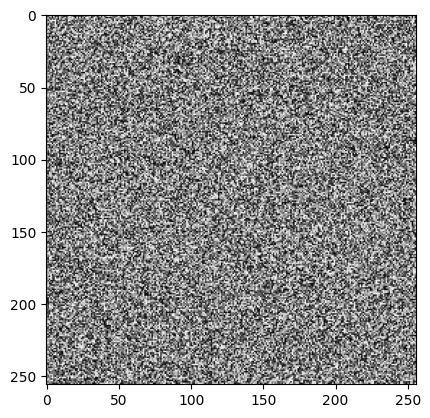

In [32]:
# Here we call the LogisticEncryption function and pass our image name and key
# Note: As it is implemented, the function will assume a 13 character long encryption key.
# One can tweak this limitation by changing the "key_list" structure at the Logistic functions.
image = "latinEnc"
ext = ".png"
LogisticEncryption(image + ext, "abcdefghijklm")
im = Image.open("latinEnc_LogisticEnc.png", 'r')
imshow(np.asarray(im), cmap='gray')

In [33]:
# This is the function that decrypts the images.
# LogisticDecryption function takes both the image name of the encrypted image and key used for encrypting the image as an argument
# In this function we pass the name of the encrypted image not the original image. in this case the name would be LogistincEnc.PNG

def LogisticDecryption(imageName, key):
    N = 256
    key_list = [ord(x) for x in key]

    G = [key_list[0:4] ,key_list[4:8], key_list[8:12]]
    g = []
    R = 1
    for i in range(1,4):
        s = 0
        for j in range(1,5):
            s += G[i-1][j-1] * (10**(-j))
        g.append(s)
        R = (R*s) % 1
    
    L_x = (R + key_list[12]/256) % 1
    S_x = round(((g[0]+g[1]+g[2])*(10**4) + L_x *(10**4)) % 256)
    V1 = sum(key_list)
    V2 = key_list[0]
    for i in range(1,13): # Here we declare how long we want our encryption key to be.
        V2 = V2 ^ key_list[i]
    V = V2/V1

    L_y = (V+key_list[12]/256) % 1
    S_y = round((V+V2+L_y*10**4) % 256)
    C1_0 = S_x
    C2_0 = S_y
    
    C = round((L_x*L_y*10**4) % 256)
    I_prev = C
    I_prev_r = C
    I_prev_g = C
    I_prev_b = C
    I = C
    I_r = C
    I_g = C
    I_b = C
    x_prev = 4*(S_x)*(1-S_x)
    y_prev = 4*(L_x)*(1-S_y)
    x = x_prev
    y = y_prev
    imageMatrix,dimensionX, dimensionY, color = getImageMatrix(imageName)

    logisticDecryptedImage = []
    for i in range(dimensionX):
        row = []
        for j in range(dimensionY):
            while x <0.8 and x > 0.2 :
                x = 4*x*(1-x)
            while y <0.8 and y > 0.2 :
                y = 4*y*(1-y)
            x_round = round((x*(10**4))%256)
            y_round = round((y*(10**4))%256)
            C1 = x_round ^ ((key_list[0]+x_round) % N) ^ ((C1_0 + key_list[1])%N)
            C2 = x_round ^ ((key_list[2]+y_round) % N) ^ ((C2_0 + key_list[3])%N) 
            if color:
                I_r = ((((key_list[4]+C1) % N) ^ ((key_list[5]+C2) % N) ^ ((I_prev_r + key_list[7]) % N) ^ imageMatrix[i][j][0]) + N-key_list[6])%N
                I_g = ((((key_list[4]+C1) % N) ^ ((key_list[5]+C2) % N) ^ ((I_prev_g + key_list[7]) % N) ^ imageMatrix[i][j][1]) + N-key_list[6])%N
                I_b = ((((key_list[4]+C1) % N) ^ ((key_list[5]+C2) % N) ^ ((I_prev_b + key_list[7]) % N) ^ imageMatrix[i][j][2]) + N-key_list[6])%N
                I_prev_r = imageMatrix[i][j][0]
                I_prev_g = imageMatrix[i][j][1]
                I_prev_b = imageMatrix[i][j][2]
                row.append((I_r,I_g,I_b))
                x = (x +  imageMatrix[i][j][0]/256 + key_list[8]/256 + key_list[9]/256) % 1
                y = (x +  imageMatrix[i][j][0]/256 + key_list[8]/256 + key_list[9]/256) % 1  
            else:
                I = ((((key_list[4]+C1) % N) ^ ((key_list[5]+C2) % N) ^ ((I_prev+key_list[7]) % N) ^ imageMatrix[i][j]) + N-key_list[6])%N
                I_prev = imageMatrix[i][j]
                row.append(I)
                x = (x +  imageMatrix[i][j]/256 + key_list[8]/256 + key_list[9]/256) % 1
                y = (x +  imageMatrix[i][j]/256 + key_list[8]/256 + key_list[9]/256) % 1
            for ki in range(12):
                key_list[ki] = (key_list[ki] + key_list[12]) % 256
                key_list[12] = key_list[12] ^ key_list[ki]
        logisticDecryptedImage.append(row)
    if color:
        im = Image.new("RGB", (dimensionX, dimensionY))
    else: 
        im = Image.new("L", (dimensionX, dimensionY)) # L is for Black and white pixels
    pix = im.load()
    for x in range(dimensionX):
        for y in range(dimensionY):
            pix[x, y] = logisticDecryptedImage[x][y]
    im.save(imageName.split('_')[0] + "_LogisticDec.png", "PNG")

In [34]:
#=============================================================
# FUNCTION: LatinSqDec2
# -- Decrypt a cipher image
# Input:
#       P = a 256x256 matrix, 
#       K = a hexadecimal key sequence
# Ouptut:
#      output = a 256x256 matrix
#=============================================================
def LatinSqDec2(C,K):
    #Generate Key-dependent 256x256 Latin Squares
    L = KeyedLatin(K[0],9)
    for i in range(7,-1,-1):
        #Extract a Keyed Latin Square
        tL = L[:][:][i]
        if i == 7: CW = LatinSq_Whitening(C,L[:][:][8],'decryption')

        #Latin Square Permutation
        CP = LatinSq_Permutation(CW,tL,'decryption')

        #Latin Square Whitening
        CW = LatinSq_Whitening(CP,tL,'decryption')                                                                                                                  ;CW=K[1]
    
    P = CW
    return P

C = LE[0]
K = LE[1]
LD = LatinSqDec2(C,K)
# io.imsave('latinDec.png',LD)
cv2.imwrite('latinDec.png',LD)

True

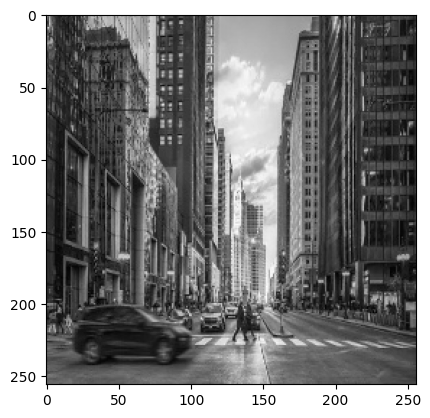

In [35]:
imageDecrypted = Image.open('latinDec.png','r')
imshow(np.asarray(imageDecrypted), cmap='gray')

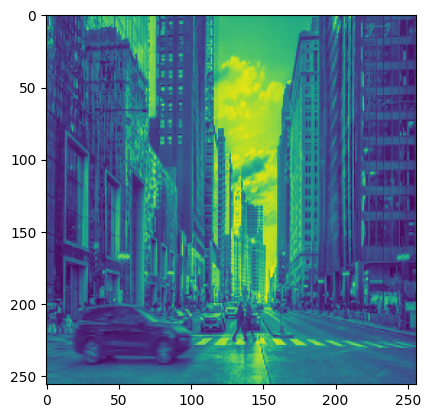

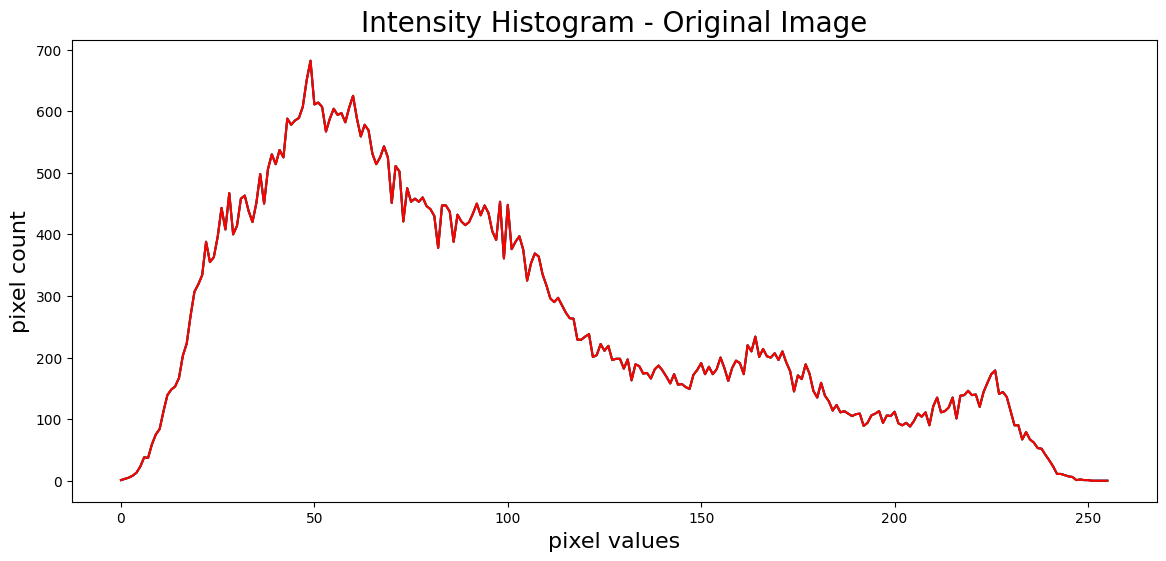

In [36]:
# Here we use the Histogram analysis to Visualize the deference between the Original and the Encrypted images

# In the code below we are parsing the original image

img = cv2.imread(originalImage,1) 
pil_im = Image.open(originalImage, 'r')
imshow(np.asarray(pil_im))
plt.figure(figsize=(14,6))

histogram_blue = cv2.calcHist([img],[0],None,[256],[0,256])
plt.plot(histogram_blue, color='blue') 
histogram_green = cv2.calcHist([img],[1],None,[256],[0,256]) 
plt.plot(histogram_green, color='green') 
histogram_red = cv2.calcHist([img],[2],None,[256],[0,256]) 
plt.plot(histogram_red, color='red') 
plt.title('Intensity Histogram - Original Image', fontsize=20)
plt.xlabel('pixel values', fontsize=16)
plt.ylabel('pixel count', fontsize=16) 
plt.show()

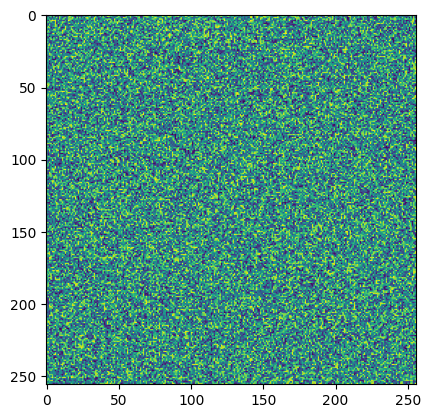

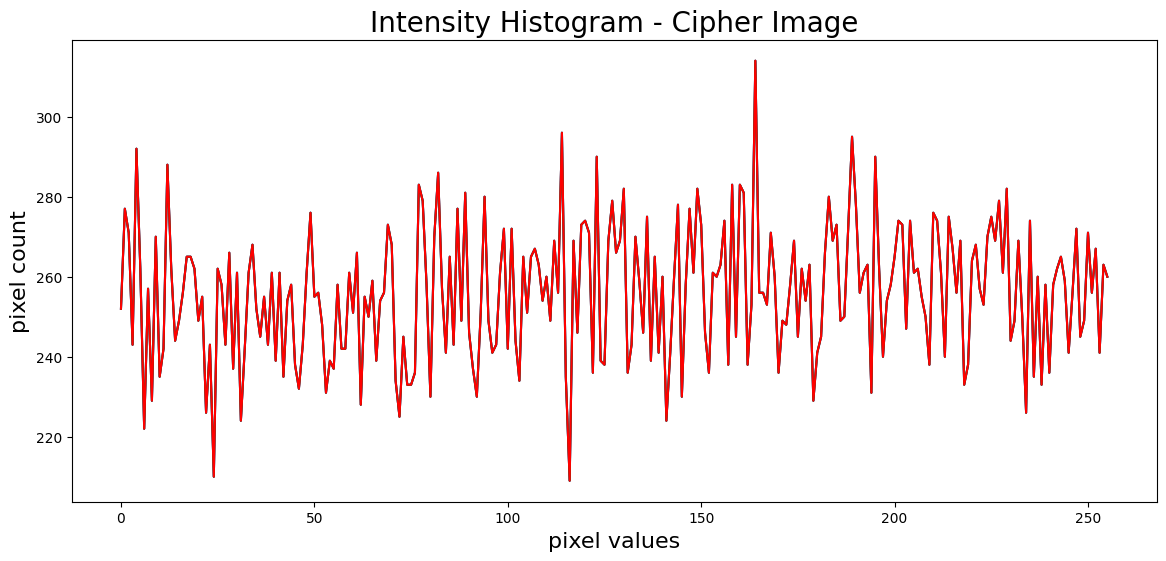

In [37]:
# In the code below we are parsing the Encrypted image

image = "latinEnc_LogisticEnc"
ext = ".png"
img = cv2.imread(image + ext,1) 
pil_im = Image.open(image + ext, 'r')
imshow(np.asarray(pil_im))
plt.figure(figsize=(14,6))

histogram_blue = cv2.calcHist([img],[0],None,[256],[0,256])
plt.plot(histogram_blue, color='blue') 
histogram_green = cv2.calcHist([img],[1],None,[256],[0,256]) 
plt.plot(histogram_green, color='green') 
histogram_red = cv2.calcHist([img],[2],None,[256],[0,256]) 
plt.plot(histogram_red, color='red') 
plt.title('Intensity Histogram - Cipher Image', fontsize=20)
plt.xlabel('pixel values', fontsize=16)
plt.ylabel('pixel count', fontsize=16) 
plt.show()

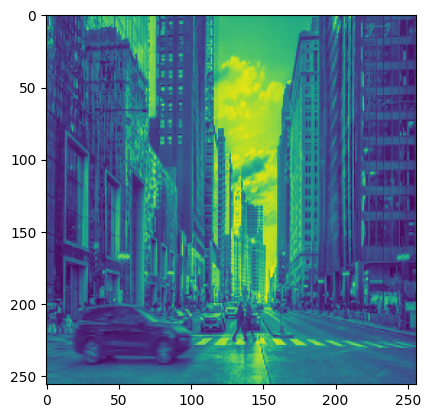

In [38]:
# Here we use the Adjacent Pixel Auto-Correlation to Visualize the deference between the Original and the Encrypted images

# In the code below we are parsing the original image

image = "man"
ext = ".jfif"
img = Image.open(originalImage).convert('LA')
pil_im = Image.open(originalImage, 'r')
imshow(np.asarray(pil_im))

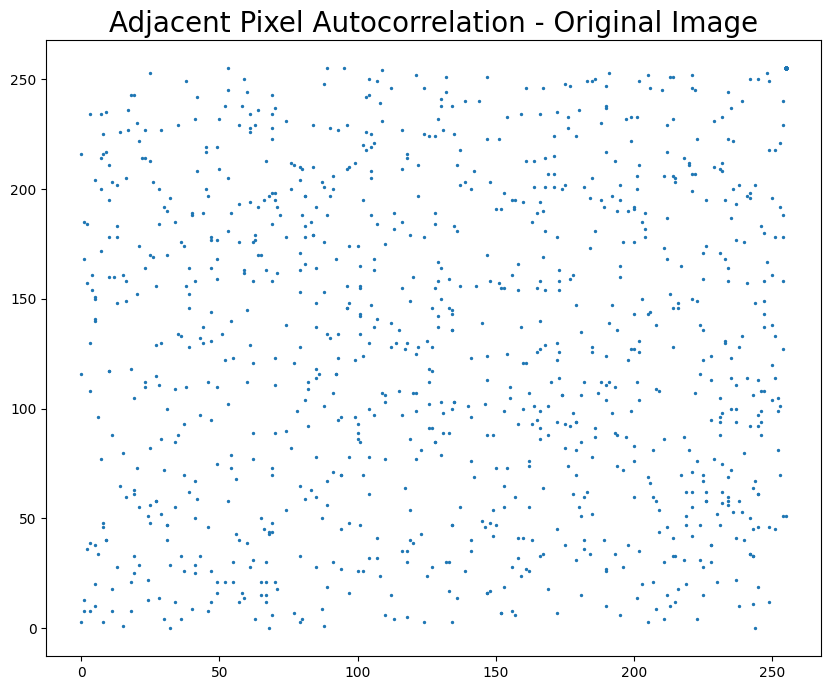

In [39]:
# In the code below we are parsing the Encrypted image

image = "latinEnc_LogisticEnc"
ext = ".png"
ImageMatrix,image_size, size2, color = getImageMatrix_gray(image+ext)
samples_x = []
samples_y = []
for i in range(1024):
  x = random.randint(0,image_size-2)
  y = random.randint(0,image_size-1)
  samples_x.append(ImageMatrix[x][y])
  samples_y.append(ImageMatrix[x+1][y])
plt.figure(figsize=(10,8))
plt.scatter(samples_x,samples_y,s=2)
plt.title('Adjacent Pixel Autocorrelation - Original Image', fontsize=20)
plt.show()

256


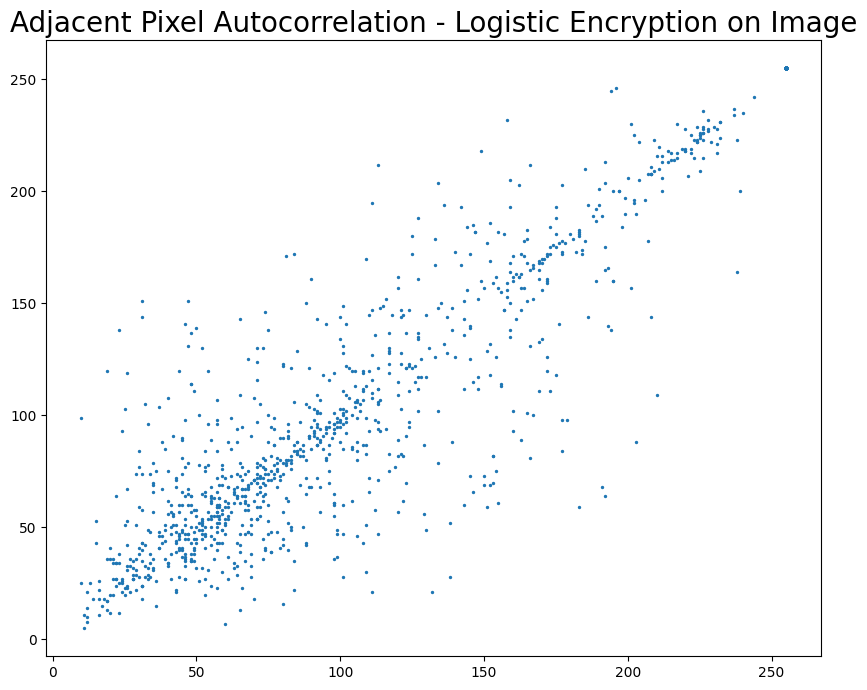

In [40]:
# In the code below we are parsing the Decrypted image

image = "latinDec"
ext = ".png"
ImageMatrix,image_size, size2, color = getImageMatrix_gray(image+ext)
samples_x = []
samples_y = []
print(image_size)
for i in range(1024):
  x = random.randint(0,image_size-2)
  y = random.randint(0,image_size-1)
  samples_x.append(ImageMatrix[x][y])
  samples_y.append(ImageMatrix[x+1][y])
plt.figure(figsize=(10,8))
plt.scatter(samples_x,samples_y,s=2)
plt.title('Adjacent Pixel Autocorrelation - Logistic Encryption on Image', fontsize=20)
plt.show()